## Echo top height detection algorithm and comparison vs VISST

This notebook detects echo top heights in regions covered by DCCs. 
It will look at the maximum height where Z > 1 dBZ.

In [717]:
import pyart
from matplotlib import pyplot as plt
%matplotlib inline
from copy import deepcopy
import numpy as np
import math
from mpl_toolkits.basemap import Basemap
from scipy import ndimage, interpolate, signal
from netCDF4 import Dataset
from matplotlib import dates
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import datetime
import glob

In [779]:
# Input the range of dates and time wanted for the collection of images
start_year = 2006
start_day = 8
start_month = 1
start_hour = 21
start_minute = 20
start_second = 0

end_year = 2006
end_month = 1
end_day = 8
end_hour = 23
end_minute = 0
end_second = 0

sounding = '/home/rjackson/data/soundings/twpsondewnpnC3.b1.20060120.231500.custom.cdf'
visst_image = '/home/rjackson/data/visst/twpvisstpx04m1rv1minnisX30.c1.20060107.003300.custom.cdf'
data_path = '/home/rjackson/multidop_grids/'
num_levels = 40

In [769]:
# Get beam crossing angle between radars
def get_bca(grid):
    berr_origin = [-12960.1,-23091.1]
    x,y = np.meshgrid(grid.x['data'], grid.y['data'])
    a = np.sqrt(np.multiply(x,x)+np.multiply(y,y))
    b = np.sqrt(pow(x-berr_origin[0],2)+pow(y-berr_origin[1],2))
    c = np.sqrt(berr_origin[0]*berr_origin[0]+berr_origin[1]*berr_origin[1])
    theta_1 = np.arccos(x/a)
    theta_2 = np.arccos((x-berr_origin[1])/b)
    return np.arccos((a*a+b*b-c*c)/(2*a*b))

def dms_to_decimal(deg, minutes, seconds):
    return deg+minutes/60+seconds/3600

# Convert seconds to midnight to a string format
def seconds_to_midnight_to_string(time_secs_after_midnight):

    hours = math.floor(time_secs_after_midnight/3600)
    minutes = math.floor((time_secs_after_midnight - hours*3600)/60)
    temp = datetime.time(int(hours), int(minutes), )
    return temp.strftime('%H%M%S')

def seconds_to_midnight_to_hm(time_secs_after_midnight):
    hours = math.floor(time_secs_after_midnight/3600)
    minutes = math.floor((time_secs_after_midnight - hours*3600)/60)
    return hours, minutes

# get_radar_times
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of Radar classes between start_time and end_time  
def get_dda_times(start_year, start_month, start_day,
                  start_hour, start_minute, end_year,
                  end_month, end_day, end_hour, 
                  end_minute, minute_interval=5):
    from datetime import datetime, timedelta
    start_time = datetime(start_year,
                      start_month,
                      start_day,
                      start_hour,
                      start_minute,
                      )
    end_time = datetime(end_year,
                      end_month,
                      end_day,
                      end_hour,
                      end_minute,
                      )

    deltatime = end_time - start_time


    if(deltatime.seconds > 0 or deltatime.minute > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = np.arange(0, no_days, 1)
    print('We are about to load grid files for ' + str(no_days) + ' days')
    

    # Find the list of files for each day
    cur_time = start_time
 
    file_list = []
    time_list = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        format_str = (data_path +
                      'cf_compliant_grid' +
                      year_str +
                      month_str +
                      day_str +
                      '*.nc')
      
        print('Looking for files with format ' + format_str)          
        data_list = glob.glob(format_str)
        
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
    
    
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        date_str = file_name[-15:-3]
        year_str = date_str[0:4]
        month_str = date_str[4:6]
        day_str = date_str[6:8]
        hour_str = date_str[8:10]
        minute_str = date_str[10:12]
        second_str = '00'
             
        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            int(minute_str),
                            0)
        time_list.append(cur_time)
        
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []
   
    for times in time_list_sorted:         
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
            
        if(cur_time - past_time >= timedelta(minutes=minute_interval)
           and cur_time >= start_time and cur_time <= end_time):
            
            time_list_final.append(cur_time)
            past_time = cur_time
                           
    return time_list_final

# Get a Radar object given a time period in the CPOL dataset
def get_grid_from_dda(time):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (data_path +
                    'cf_compliant_grid' +
                     year_str +
                     month_str +
                     day_str +
                     hour_str +
                     minute_str + '.nc')
    
    radar = pyart.io.read_grid(file_name_str)
    return radar

In [775]:
# Plot the radars from given time.

times = get_dda_times(start_year, start_month, start_day,
                      start_hour, start_minute, end_year,
                      end_month, end_day, end_hour, 
                      end_minute, minute_interval=0)
print(times)

We are about to load grid files for 1 days
Looking for files with format /home/rjackson/multidop_grids/cf_compliant_grid20060108*.nc
[datetime.datetime(2006, 1, 8, 22, 40), datetime.datetime(2006, 1, 8, 22, 50), datetime.datetime(2006, 1, 8, 23, 0)]


In [654]:
time_to_choose = times[6]
pyart_grid = get_grid_from_dda(time_to_choose)
bca = get_bca(pyart_grid)
w = pyart_grid.fields['upward_air_velocity']['data']
z = pyart_grid.fields['reflectivity']['data']
bca = np.ma.masked_invalid(bca)

for levels in range(0,num_levels-1):
    w_outside_updraft = np.logical_or(w[levels] < 1, w[levels] > 99.0)
    outside_dd_lobes = np.logical_or(bca < math.pi/6, bca > 5*math.pi/6)
    w[levels] = np.ma.masked_where(np.logical_or(w_outside_updraft,
                                                 outside_dd_lobes), w[levels])
    z[levels] = np.ma.masked_where(np.logical_or(w_outside_updraft,
                                                 outside_dd_lobes), z[levels])

grid_x = pyart_grid.point_x['data']
grid_y = pyart_grid.point_y['data']
grid_z = pyart_grid.point_z['data']

/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in arccos
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in less
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater


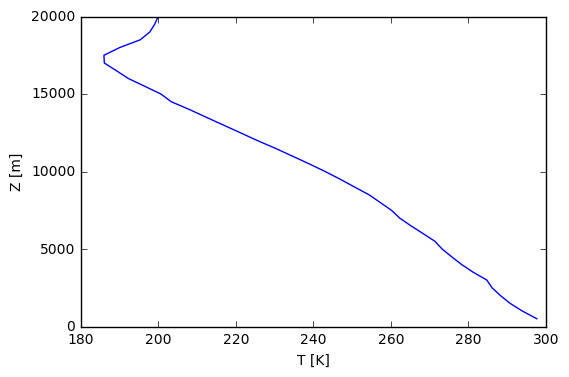

In [735]:
Sounding_netcdf = Dataset(sounding, mode='r')
Time = Sounding_netcdf.variables['time_offset'][:]
base_time = Sounding_netcdf.variables['base_time'][:]
alt = Sounding_netcdf.variables['alt'][:]
temp = Sounding_netcdf.variables['tdry'][:]

Tz = interpolate.interp1d(alt, temp+273.15)
grid_temp = Tz(grid_z)
plt.plot(grid_temp[:,1,1], grid_z[:,1,1])
plt.xlabel('T [K]')
plt.ylabel('Z [m]')

(8991,)
(8991,)


/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


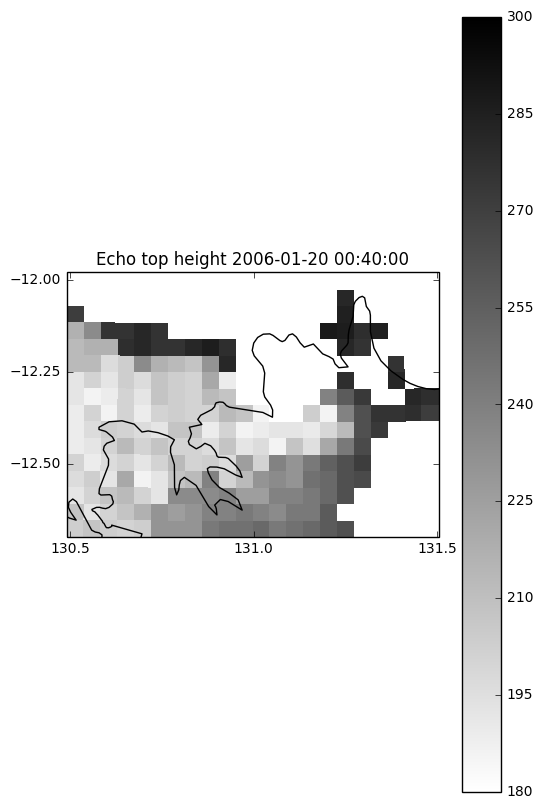

In [710]:
# Set mask to exclude data less than 15 km from CPOL where radar does not sample top
resolution = 5
array_shape = grid_z.shape
echo_top = np.zeros((array_shape[1],array_shape[2]))
echo_temp = np.zeros((array_shape[1],array_shape[2]))
for i in range(0, array_shape[1]):
    for j in range(0, array_shape[2]):
        in_cloud = np.where(z[:,i,j] > 0)
        if(len(in_cloud[0]) > 0):
            in_cloud = in_cloud[0][-1]
            echo_top[i,j] = grid_z[in_cloud,i,j]
            echo_temp[i,j] = grid_temp[in_cloud,i,j]
        else:
            echo_top[i,j] = np.nan
            echo_temp[i,j] = np.nan
        
        if(math.sqrt(math.pow(grid_x[0,i,j],2) +
                     math.pow(grid_y[0,i,j],2)) < 15000):
            echo_top[i,j] = np.nan
            echo_temp[i,j] = np.nan
# Regrid data to multidop's grid
x = pyart_grid.point_longitude['data'][0,
                                       ::resolution, 
                                       ::resolution]
y = pyart_grid.point_latitude['data'][0,
                                      ::resolution, 
                                      ::resolution]
# Grid echo top height to coarser resolution
Lon = pyart_grid.point_longitude['data'][0]
Lat = pyart_grid.point_latitude['data'][0]
Lon = Lon.flatten()
Lat = Lat.flatten()
echo_top = echo_top.flatten()
echo_temp = echo_temp.flatten()
print(echo_top.shape)
print(Lat.shape)
echo_temp = interpolate.griddata((Lon,Lat), echo_temp, (x,y), method='linear')
plt.figure(figsize=(6,10))
plt.subplot(211)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')

ax.set_xticks([130, 130.5, 131, 131.5, 132], crs=ccrs.PlateCarree())
ax.set_yticks([-14, -13.5, -13, -12.5, -12.25,
               -12, -11,-10.5,], crs=ccrs.PlateCarree())
plt.pcolormesh(x,
               y,
               echo_temp,
               cmap=plt.get_cmap('gray_r'))
plt.colorbar()
plt.clim([180, 300])
plt.title('Echo top height ' + str(time_to_choose))

#plt.subplot(212)
#ax = plt.axes(projection=ccrs.PlateCarree())
#ax.coastlines(resolution='10m')

#ax.set_xticks([130, 130.5, 131, 131.5, 132], crs=ccrs.PlateCarree())
#ax.set_yticks([-14, -13.5, -13, -12.5, -12.25,
#               -12, -11,-10.5,], crs=ccrs.PlateCarree())
#plt.pcolormesh(pyart_grid.point_longitude['data'][0],
#               pyart_grid.point_latitude['data'][0],
#               z[5],
#               cmap=plt.get_cmap('jet'))
#plt.colorbar()
#plt.clim([0, 60])
#plt.title('Reflectivity')

## Compare VISST brightness temperatures vs. echo top temperatures

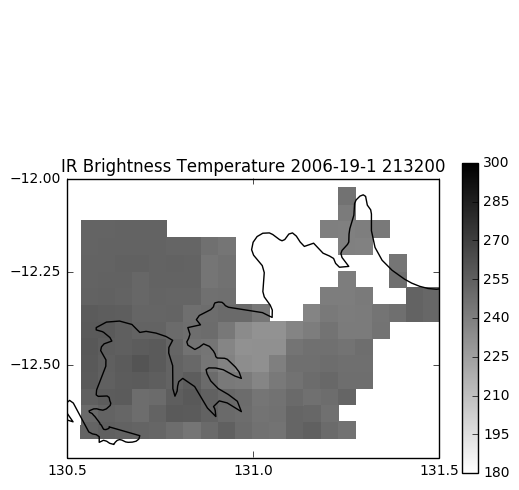

In [780]:
i = 2
cdf_data = Dataset(visst_image, mode='r')

# Load lat, lon, and time parameters - try statement for 24-hourly data, except for daily data

Latitude = cdf_data.variables['latitude']
Longitude = cdf_data.variables['longitude']
Time = cdf_data.variables['image_times']
NumPixels = cdf_data.variables['image_numpix']
year = 2006
day = 19
month = 1
# Load brightness temperature
IRBrightness = cdf_data.variables['temperature_ir']

frame = 21

j = frame

convective_regions = IRBrightness[:] < 240
Darwin_Lat = dms_to_decimal(-12, 25, 28.56)
Darwin_Lon = dms_to_decimal(130, 53, 29.75)

cpol_latitude = -12.249166
cpol_longitude = 131.04445

# Get Lat and Lon for specific frame
Lat = Latitude[(int(j)*int(NumPixels[j])):(int(j+1)*int(NumPixels[j])-1)]
Lon = Longitude[(int(j)*int(NumPixels[j])):(int(j+1)*int(NumPixels[j])-1)]

# Set up projection
plt.clf()
m = Basemap(width=500000, height=500000,
            resolution='l', projection='stere',
            lat_0=cpol_latitude,
            lon_0=cpol_longitude)

darwin_x, darwin_y = m(cpol_latitude, cpol_longitude)

# Regrid data to multidop's grid
x = pyart_grid.point_longitude['data'][0,
                                       ::resolution, 
                                       ::resolution]
y = pyart_grid.point_latitude['data'][0,
                                      ::resolution, 
                                      ::resolution]

index = j
data = IRBrightness[(int(j)*int(NumPixels[j])):(int(j+1)*int(NumPixels[j])-1)]
data_gridded = interpolate.griddata((Lon,Lat), data, (x,y), method='nearest')
lat_gridded = interpolate.griddata((Lon,Lat), Lat, (x,y))
lon_gridded = interpolate.griddata((Lon,Lat), Lon, (x,y))
lat_bounds = np.logical_or(lat_gridded < -12.75,
                           lat_gridded > -12)
lon_bounds = np.logical_or(lon_gridded < 130.5,
                           lon_gridded > 131.5)
masked_region = np.logical_or(lat_bounds, lon_bounds)
masked_region = np.logical_or(masked_region, 
                              np.isnan(echo_temp))
data_masked = np.ma.array(data_gridded)
data_masked = np.ma.masked_where(masked_region, data_gridded)
# Plot the masked data
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
plt.pcolormesh(x,y,data_masked, cmap='gray_r', vmin=190, vmax=270)
plt.text(Darwin_Lon, Darwin_Lat,
         'Darwin',
         fontweight='bold',
         color='white',
         )
plt.plot(Darwin_Lon, Darwin_Lat, 'w.')
ax.set_xticks([130, 130.5, 131, 131.5, 132], crs=ccrs.PlateCarree())
ax.set_yticks([-14, -13.5, -13, -12.5, -12.25,
               -12, -11,-10.5,], crs=ccrs.PlateCarree())
ax.set_xlim([130.5, 131.5])
ax.set_ylim([-12.75, -12])
plt.clim([180, 300])
plt.title('IR Brightness Temperature '
          + str(year)
          + '-'
          + str(day)
          + '-'
          + str(month)
          + ' '
          + seconds_to_midnight_to_string(Time[frame]))
plt.colorbar()

/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


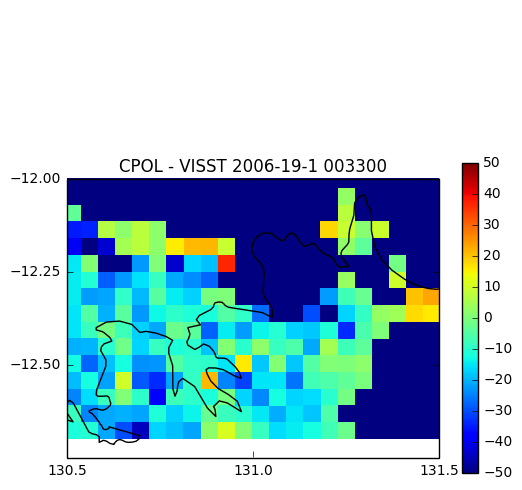

In [707]:
# Plot the masked data
ax2 = plt.axes(projection=ccrs.PlateCarree())
ax2.coastlines(resolution='10m')
plt.pcolormesh(x,y,echo_temp-data_gridded, cmap='jet', vmin=190, vmax=270)
plt.text(Darwin_Lon, Darwin_Lat,
         'Darwin',
         fontweight='bold',
         color='white',
         )
plt.plot(Darwin_Lon, Darwin_Lat, 'w.')
ax2.set_xticks([130, 130.5, 131, 131.5, 132], crs=ccrs.PlateCarree())
ax2.set_yticks([-14, -13.5, -13, -12.5, -12.25,
               -12, -11,-10.5,], crs=ccrs.PlateCarree())
ax2.set_xlim([130.5, 131.5])
ax2.set_ylim([-12.75, -12])
plt.clim([-50, 50])
plt.title('CPOL - VISST '
          + str(year)
          + '-'
          + str(day)
          + '-'
          + str(month)
          + ' '
          + seconds_to_midnight_to_string(Time[frame]))
plt.colorbar()

/home/rjackson/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


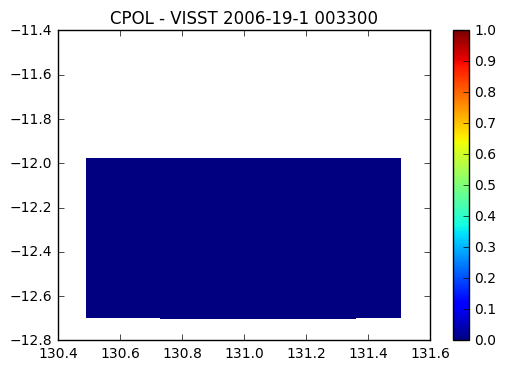

In [659]:
corr = signal.correlate2d(echo_temp, data_gridded, boundary='symm', mode='same')
ax.coastlines(resolution='10m')
plt.pcolormesh(x,y,corr, cmap='jet', vmin=0, vmax=1)
plt.plot(Darwin_Lon, Darwin_Lat, 'w.')
ax.set_xticks([130, 130.5, 131, 131.5, 132], crs=ccrs.PlateCarree())
ax.set_yticks([-14, -13.5, -13, -12.5, -12.25,
               -12, -11,-10.5,], crs=ccrs.PlateCarree())
ax.set_xlim([130.5, 131.5])
ax.set_ylim([-12.75, -12])
plt.clim([0, 1])
plt.title('CPOL - VISST '
          + str(year)
          + '-'
          + str(day)
          + '-'
          + str(month)
          + ' '
          + seconds_to_midnight_to_string(Time[frame]))
plt.colorbar()

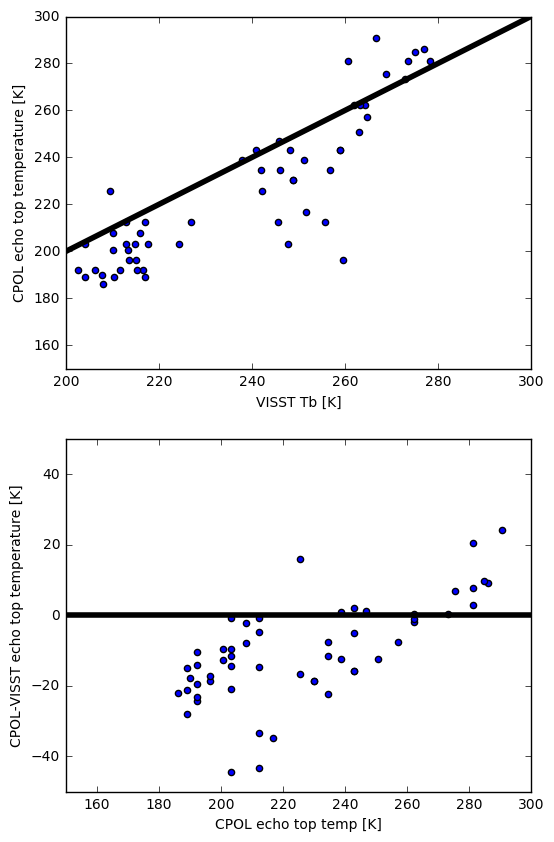

In [666]:
plt.figure(figsize=(6,10))
plt.subplot(211)
plt.scatter(data_gridded, echo_temp)
plt.plot([1, 300], [1, 300], linewidth=4, color='k')
plt.xlim([200, 300])
plt.ylim([150, 300])
plt.xlabel('VISST Tb [K]')
plt.ylabel('CPOL echo top temperature [K]')

plt.subplot(212)
plt.scatter(echo_temp, echo_temp-data_gridded)
plt.plot([150, 300], [0, 0], linewidth=4, color='k')
plt.xlim([150, 300])
plt.ylim([-50, 50])
plt.xlabel('CPOL echo top temp [K]')
plt.ylabel('CPOL-VISST echo top temperature [K]')

/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less_equal
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less_equal
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater_equal
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in less


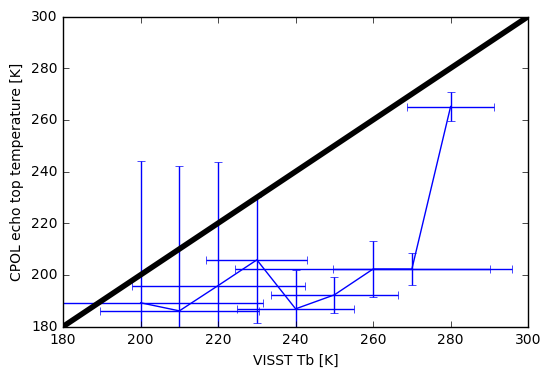

In [621]:
tb_delta = 10
avg_bins = np.arange(200, 300, tb_delta)
quartiles_x = np.zeros((len(avg_bins)-1,3))
quartiles_y = np.zeros((len(avg_bins)-1,3))
data_gridded[np.logical_or(data_gridded <= 0,
                           echo_temp <= 0)] = np.nan
echo_temp[np.logical_or(data_gridded <= 0,
                        echo_temp <= 0)] = np.nan
for i in range(0, len(avg_bins)-1):
    x_restrictions = np.logical_and(data_gridded >= avg_bins[i],
                                    data_gridded < avg_bins[i+1])
    y_restrictions = np.logical_and(echo_temp >= avg_bins[i],
                                    echo_temp < avg_bins[i+1])
    quartiles_y[i,:] = np.nanpercentile(echo_temp[x_restrictions],
                                        [5, 50, 95])
    quartiles_x[i,:] = np.nanpercentile(data_gridded[y_restrictions],
                                        [5, 50, 95])

plt.errorbar(avg_bins[:-1], 
             quartiles_y[:,0], 
             xerr=quartiles_y[:,2]-quartiles_y[:,1],
             yerr=quartiles_x[:,2]-quartiles_x[:,1])
plt.plot([1, 300], [1, 300], linewidth=4, color='k')
plt.xlim([180, 300])
plt.ylim([180, 300])   
plt.xlabel('VISST Tb [K]')
plt.ylabel('CPOL echo top temperature [K]')

## Echo top heights CPOL vs VISST for 2 months during TWP-ICE

/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in less
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater


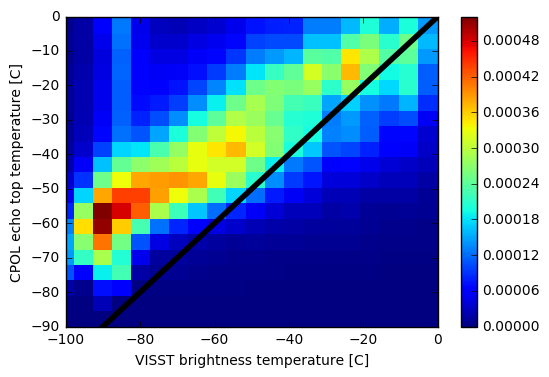

In [818]:
ncdataset = Dataset('/home/rjackson/data/echo_top_heights_TWP-ICE.cdf',
                    mode='r')
cpol_T = ncdataset.variables['cpol_T_echo_top'][:]
visst_Tv = ncdataset.variables['visst_Tv'][:]
years = ncdataset.variables['year'][:]
months = ncdataset.variables['hour'][:]
days = ncdataset.variables['day'][:]
hours = ncdataset.variables['hour'][:]
minutes = ncdataset.variables['minute'][:]
seconds = ncdataset.variables['second'][:]
range_excluded = np.logical_or(cpol_T < 150,
                               cpol_T > 273)
visst_range_excluded = np.logical_or(visst_Tv <= 170,
                                     visst_Tv >= 273)
cpol_T[np.logical_or(range_excluded,
                     visst_range_excluded)] = np.nan
visst_Tv[np.logical_or(range_excluded,
                       visst_range_excluded)] = np.nan
tb_delta = 10
avg_bins = np.arange(200, 300, tb_delta)
quartiles = np.zeros((len(avg_bins)-1,3))

array1 = visst_Tv[np.logical_and(~np.isnan(visst_Tv),
                                 ~np.isnan(cpol_T))]
array2 = cpol_T[np.logical_and(~np.isnan(visst_Tv),
                                 ~np.isnan(cpol_T))]
hist, bins1, bins2 = np.histogram2d(array1.flatten(), 
                                    array2.flatten(), 
                                    bins=20, normed=True)
bins1_grid, bins2_grid = np.meshgrid(bins1, bins2)
plt.pcolormesh(bins1_grid-273.15, bins2_grid-273.15, hist, cmap='jet')
plt.plot([-120, 300], [-120, 300], linewidth=4, color='k')
plt.xlim([-100, 0])
plt.ylim([-90, 0])  
plt.xlabel('VISST brightness temperature [C]')
plt.ylabel('CPOL echo top temperature [C]')
plt.colorbar()

/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  war

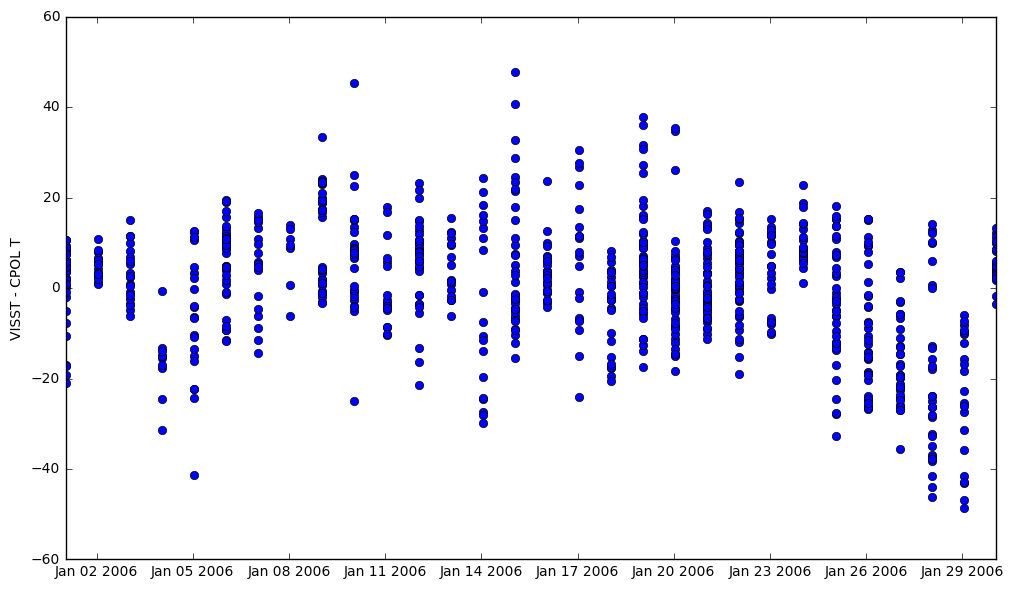

In [767]:
datenums = []
visst_Tvm = []
cpol_Tm = []
for i in range(0,len(days)):
    datenums.append(dates.date2num(datetime.datetime(year=int(years[i]),
                                                     month=int(months[i]),
                                                     day=int(days[i]),
                                                     hour=int(hours[i]),
                                                     minute=int(minutes[i]))))
    visst_Tvm.append(np.nanmean(visst_Tv[i]))
    cpol_Tm.append(np.nanmean(cpol_T[i]))

visst_Tvm = np.array(visst_Tvm)
cpol_Tm = np.array(cpol_Tm)
plt.figure(figsize=(12,7))
plt.plot_date(datenums, visst_Tvm-cpol_Tm)
plt.ylabel('VISST - CPOL T')

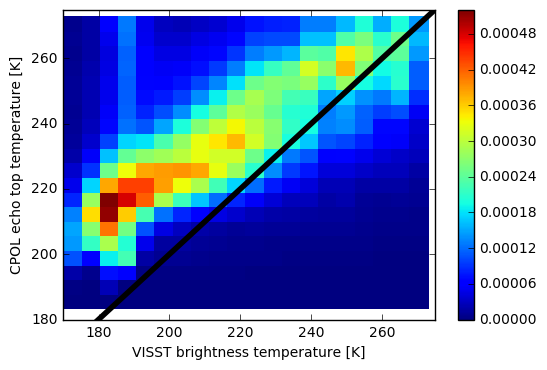

In [813]:
array1 = visst_Tv[np.logical_and(~np.isnan(visst_Tv),
                                 ~np.isnan(cpol_T))]
array2 = cpol_T[np.logical_and(~np.isnan(visst_Tv),
                                 ~np.isnan(cpol_T))]
hist, bins1, bins2 = np.histogram2d(array1.flatten(), 
                                    array2.flatten(), 
                                    bins=20, normed=True)
bins1_grid, bins2_grid = np.meshgrid(bins1, bins2)
plt.pcolormesh(bins1_grid, bins2_grid, hist)
plt.plot([1, 300], [1, 300], linewidth=4, color='k')
plt.xlim([170, 275])
plt.ylim([180, 275])   
plt.colorbar()
plt.xlabel('VISST brightness temperature [K]')
plt.ylabel('CPOL echo top temperature [K]')